In [90]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, RecurrentNetwork, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, TorchNormalizer
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss, RMSE

from importlib import reload



In [91]:
#Download the VIX index from yahoo finance
import yfinance as yf

vix = yf.download("^VIX")

#Compute the first difference of the VIX index
vix['Adj Close'] = vix['Adj Close'].diff()
vix = vix.dropna()

#Construct Pandas dataframe with the VIX index, the Date, a time index starting from 0 and a series column to identify the series

vix = vix.reset_index()
vix['time_idx'] = vix.index
vix['series'] = 0
#Change column name
vix = vix.rename(columns={'Adj Close':'value', 'Date':'date'})
#Drop columns
vix = vix.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
vix.head()

data = vix.copy()

[*********************100%%**********************]  1 of 1 completed


In [92]:
data = data.astype(dict(series=str))

# create dataset and dataloaders
max_encoder_length = 100
max_prediction_length = 50

validation_cutoff = data["time_idx"].max() - 1000
training_cutoff = validation_cutoff - max_prediction_length


context_length = max_encoder_length
prediction_length = max_prediction_length

data.head()

,date,value,time_idx,series
0,1990-01-03,0.950001,0,0
1,1990-01-04,1.029999,1,0
2,1990-01-05,0.890001,2,0
3,1990-01-08,0.150000,3,0
4,1990-01-09,1.940001,4,0


Optimal parameters:  alpha_mu = 6.680592786680578e-05,  alpha_sigma = 0.04735367270854723, mu_0 = 1.1173695738200655, sigma2_0 = 3.027805416304621, beta_mu = 0.8626048574946424, beta_sigma = 0.9814929830210826, omega_mu = -0.0025302766402086297, omega_sigma = 0.016449949634624563
alpha_mu:  6.680592786680578e-05 alpha_sigma:  0.04735367270854723 beta_mu:  0.8626048574946424 beta_sigma:  0.9814929830210826 omega_mu:  -0.0025302766402086297 omega_sigma:  0.016449949634624563 nu:  20


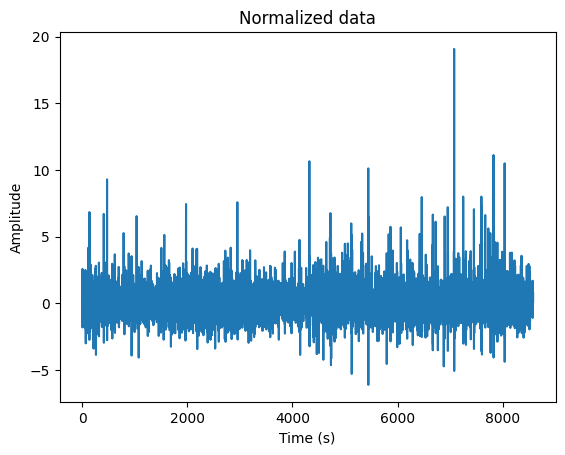

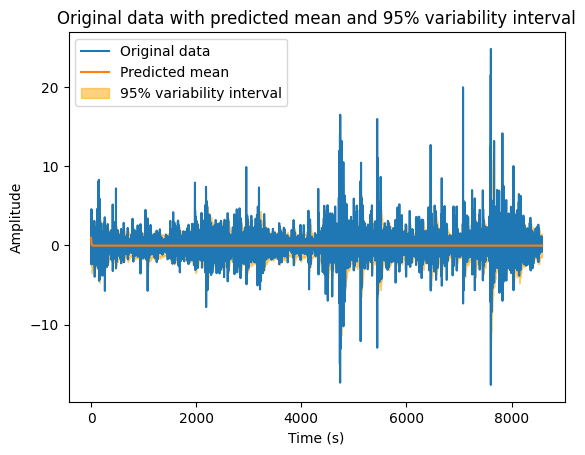

In [93]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
from GAS_norm import SD_Normalization_Student
import numpy as np

#Set the normalization strngth for the mean and the variance from 0 to 1
mean_norm_strength = 1
var_norm_strength = 1
degrees_freedom = 20

norm_strength = [mean_norm_strength*0.5, var_norm_strength*0.5]


mu_list, sigma2_list, y_norm, alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu = SD_Normalization_Student(data['value'], data['value'][:validation_cutoff],  mode='predict', norm_strength=norm_strength, degrees_freedom=degrees_freedom)

gas_params = alpha_mu, alpha_sigma, beta_mu, beta_sigma, omega_mu, omega_sigma, nu, norm_strength

#print all gas parameters in one line
print('alpha_mu: ', alpha_mu, 'alpha_sigma: ', alpha_sigma, 'beta_mu: ', beta_mu, 'beta_sigma: ', beta_sigma, 'omega_mu: ', omega_mu, 'omega_sigma: ', omega_sigma, 'nu: ', nu)


#Plot the normalized data

plt.plot(data['time_idx'][1:], y_norm[1:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

plt.plot(data['time_idx'], data['value'], label='Original data')
plt.plot(data['time_idx'], mu_list, label='Predicted mean')
plt.fill_between(data['time_idx'], mu_list-1.96*np.sqrt(sigma2_list), mu_list+1.96*np.sqrt(sigma2_list), alpha=0.5, label='95% variability interval', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original data with predicted mean and 95% variability interval')
plt.legend()

In [94]:
#Add mean and variance to the dataframe

data['mu'] = mu_list
data['sigma2'] = sigma2_list

data.head()

,date,value,time_idx,series,mu,sigma2
0,1990-01-03,0.950001,0,0,0.961309,3.165402
1,1990-01-04,1.029999,1,0,0.826703,2.978234
2,1990-01-05,0.890001,2,0,0.710591,2.803191
3,1990-01-08,0.150000,3,0,0.610397,2.656240
4,1990-01-09,1.940001,4,0,0.524075,2.594344


In [95]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=['mu', 'sigma2'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    target_normalizer= TorchNormalizer(method="identity", center=False),
    scalers={'mu': None, 'sigma2': None}
)

validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx <= validation_cutoff], min_prediction_idx=training_cutoff + 1)
test = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=validation_cutoff + 1)

batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, shuffle=False
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, shuffle=False
)

test_dataloader = test.to_dataloader(
    train=False, batch_size=1, num_workers=0, shuffle=False
)

In [96]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.7766)

In [97]:
from importlib import reload
import GAS_LSTM
reload(GAS_LSTM)
from GAS_LSTM import GAS_LSTM, GAS_MAE

pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = GAS_LSTM.from_dataset(
    training,
    cell_type="LSTM",   
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=GAS_MAE(),
    optimizer="Adam",
    gas_params= gas_params,
)

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[-0.0711]]), tensor([[0.0236]]), tensor([[0.0235]]), tensor([[0.0235]]), tensor([[0.0236]]), tensor([[0.0236]]), tensor([[0.0237]]), tensor([[0.0237]]), tensor([[0.0237]]), tensor([[0.0237]]), tensor([[0.0237]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]]), tensor([[0.0238]])

[tensor([[-0.0711]]), tensor([[-0.0109]]), tensor([[-0.0099]]), tensor([[-0.0061]]), tensor([[-0.0016]]), tensor([[0.0025]]), tensor([[0.0057]]), tensor([[0.0080]]), tensor([[0.0095]]), tensor([[0.0105]]), tensor([[0.0110]]), tensor([[0.0113]]), tensor([[0.0114]]), tensor([[0.0114]]), tensor([[0.0114]]), tensor([[0.0114]]), tensor([[0.0114]]), tensor([[0.0114]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.0113]]), tensor([[0.011

`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]
Learning rate set to 0.00028183829312644534
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_20524918-7df6-4aee-9151-fd4172c5d2af.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_20524918-7df6-4aee-9151-fd4172c5d2af.ckpt


suggested learning rate: 0.00028183829312644534


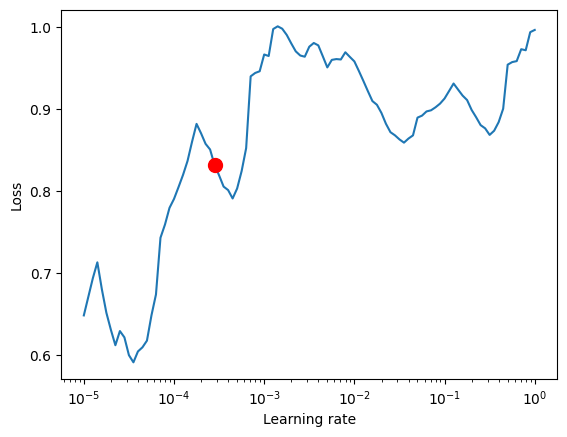

In [98]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [99]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", filename="best_model", mode="min", save_top_k=1)
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, checkpoint_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = GAS_LSTM.from_dataset(
    training,
    cell_type="LSTM",
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=GAS_MAE(), 
    gas_params= gas_params,
)

net.hparams.learning_rate = res.suggestion()

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | GAS_MAE        | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.6 K
4 | output_projector | Linear         | 31    
5 | AR_GAS           | AR_GAS         | 0     
----------------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


Epoch 4:   2%|▏         | 1/50 [00:01<01:30,  0.54it/s, v_num=64, train_loss_step=1.270, val_loss=0.775, train_loss_epoch=0.941] 

In [100]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = GAS_LSTM.load_from_checkpoint(best_model_path)
print(best_model_path)

c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\lightning_logs\version_64\checkpoints\best_model.ckpt


In [101]:
#best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
print(MAE()(predictions.output, predictions.y))

net = best_model

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[-0.0711]]), tensor([[-0.1531]]), tensor([[-0.1482]]), tensor([[-0.1376]]), tensor([[-0.1254]]), tensor([[-0.1139]]), tensor([[-0.1042]]), tensor([[-0.0967]]), tensor([[-0.0911]]), tensor([[-0.0873]]), tensor([[-0.0848]]), tensor([[-0.0833]]), tensor([[-0.0826]]), tensor([[-0.0823]]), tensor([[-0.0822]]), tensor([[-0.0823]]), tensor([[-0.0825]]), tensor([[-0.0827]]), tensor([[-0.0828]]), tensor([[-0.0830]]), tensor([[-0.0831]]), tensor([[-0.0832]]), tensor([[-0.0832]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.

In [102]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[-0.0711]]), tensor([[-0.1531]]), tensor([[-0.1482]]), tensor([[-0.1376]]), tensor([[-0.1254]]), tensor([[-0.1139]]), tensor([[-0.1042]]), tensor([[-0.0967]]), tensor([[-0.0911]]), tensor([[-0.0873]]), tensor([[-0.0848]]), tensor([[-0.0833]]), tensor([[-0.0826]]), tensor([[-0.0823]]), tensor([[-0.0822]]), tensor([[-0.0823]]), tensor([[-0.0825]]), tensor([[-0.0827]]), tensor([[-0.0828]]), tensor([[-0.0830]]), tensor([[-0.0831]]), tensor([[-0.0832]]), tensor([[-0.0832]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.

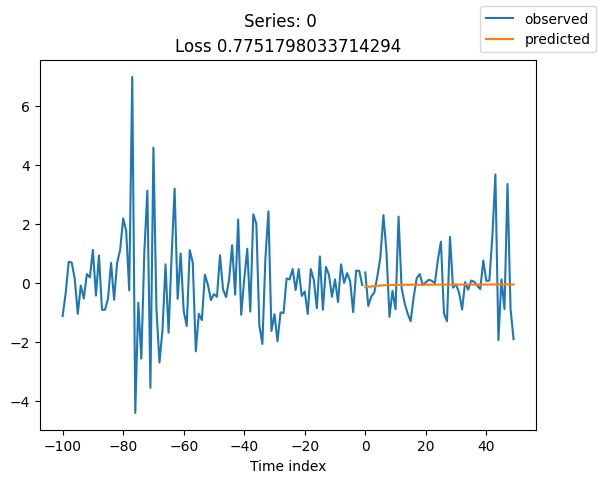

In [103]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")
    

In [104]:
#Test the model on the test set

predictions = best_model.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"), mode='raw', return_index=True, return_y=True, return_x=True)



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[tensor([[-1.5613]]), tensor([[-0.3552]]), tensor([[-0.2619]]), tensor([[-0.1913]]), tensor([[-0.1411]]), tensor([[-0.1080]]), tensor([[-0.0878]]), tensor([[-0.0768]]), tensor([[-0.0719]]), tensor([[-0.0707]]), tensor([[-0.0716]]), tensor([[-0.0734]]), tensor([[-0.0756]]), tensor([[-0.0776]]), tensor([[-0.0793]]), tensor([[-0.0807]]), tensor([[-0.0817]]), tensor([[-0.0825]]), tensor([[-0.0830]]), tensor([[-0.0832]]), tensor([[-0.0834]]), tensor([[-0.0835]]), tensor([[-0.0835]]), tensor([[-0.0835]]), tensor([[-0.0835]]), tensor([[-0.0834]]), tensor([[-0.0834]]), tensor([[-0.0834]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.0833]]), tensor([[-0.

Finding best initial lr:  87%|████████▋ | 87/100 [32:49<04:54, 22.63s/it]


In [105]:
print(MAE()(predictions.output.prediction.squeeze(), predictions.x['decoder_target']))


tensor(1.2920)


0
105
211
316
422
527
633
738
844
950


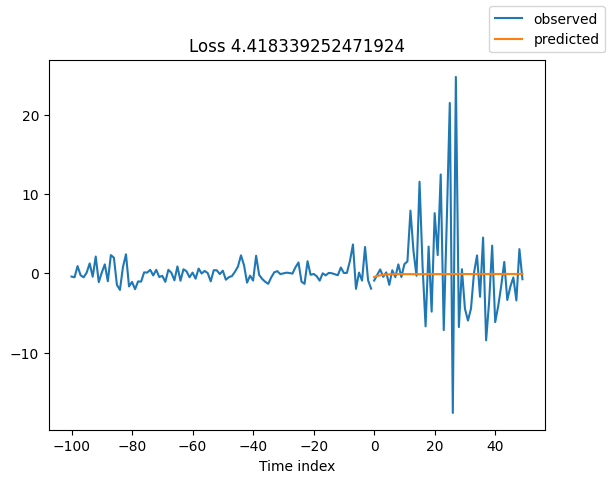

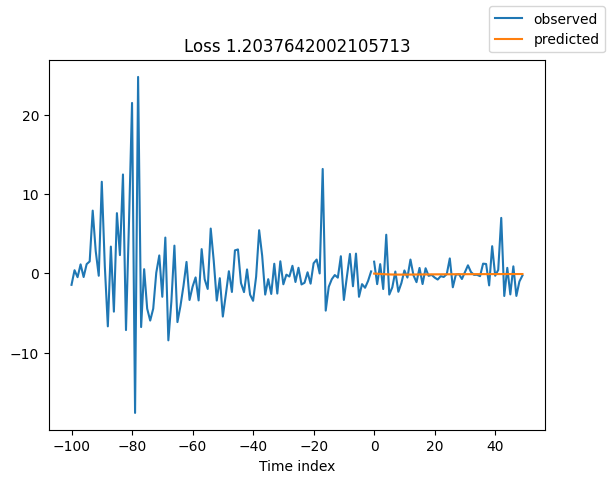

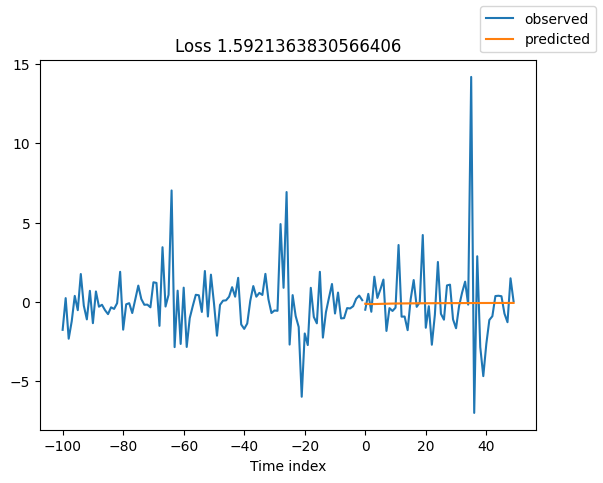

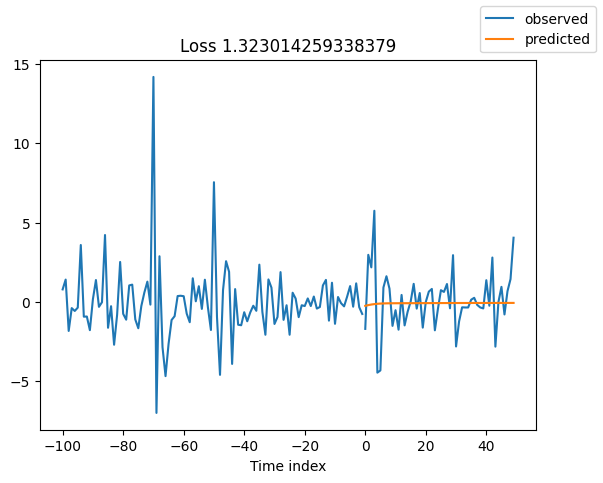

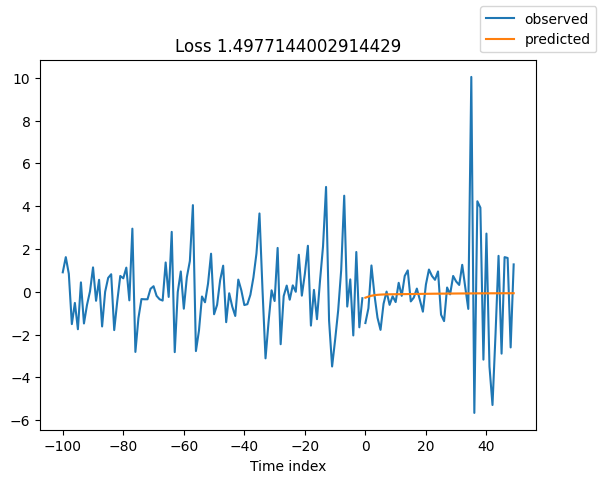

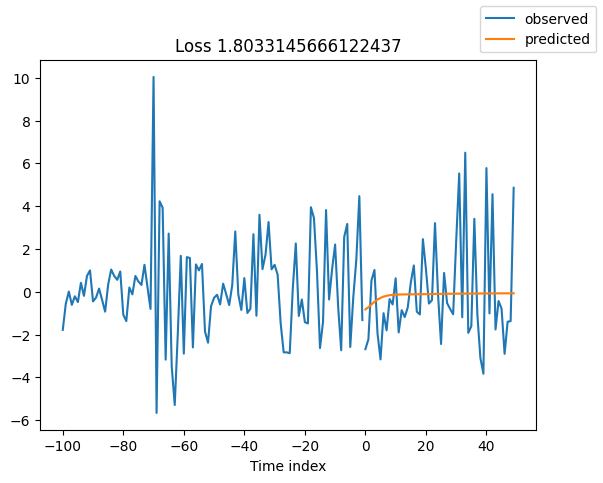

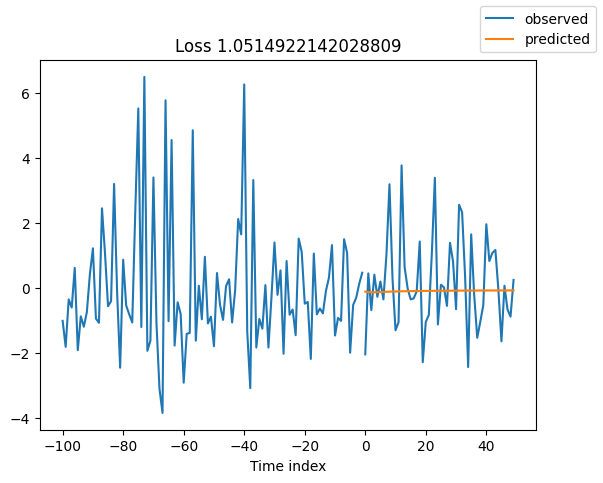

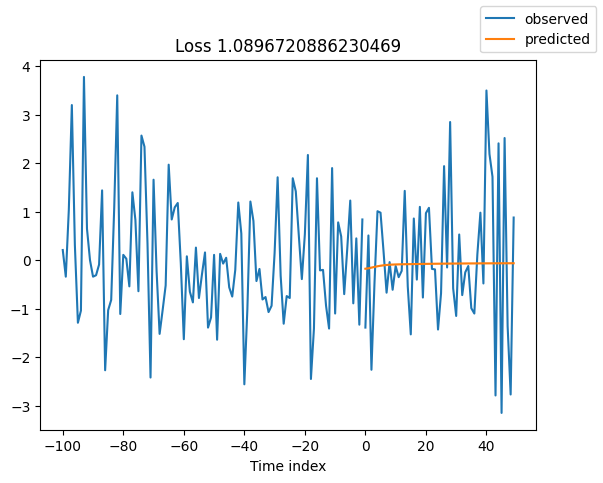

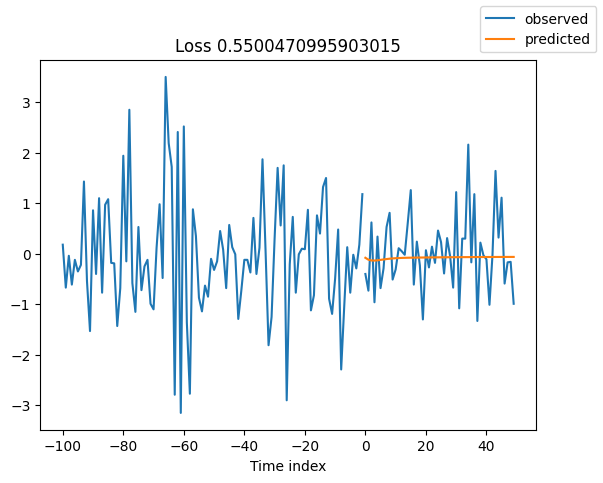

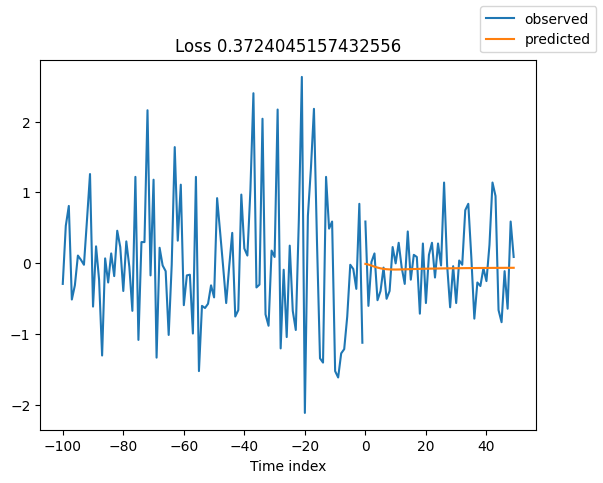

In [106]:

for i in np.linspace(0, predictions.x['encoder_target'].shape[0]-1, 10, dtype=int):
    print(i)
    best_model.plot_prediction(predictions.x, predictions.output, idx=i, add_loss_to_title=True)

951